# VASP bandstructure workflow using MatMethods

In this excercise we will use the [MatMethods](https://github.com/hackingmaterials/MatMethods.git) package to compute the bandstructre of silicon.

**MatMethods:**

- Successor to **MPWorks**: the software framework that powers the MaterialsProject

- Like MPWorks it is built on top of state-of-the-art open-source libraries: **pymatgen, custodian, and FireWorks**
    
- Unlike MPWorks, MatMethods provides a much **cleaner and simpler interface** for composing complex workflows.

- Features:
 
    - Provides “standard” workflows for a wide variety of desired materials properties - optimized structures, band structures, electronic transport properties, dielectric constants, and much more. Just provide a crystal structure (that’s it!) and let MatMethods set up a complete workflow that provides the property you are interested in. You can do this for a single material, 100 materials, or 100,000 materials.

    - One can easily change “standard workflows” - whether that is changing some of the default calculation parameters or recomposing the workflow (adding new calculations, removing steps, etc.) - using a very expressive syntax. One can compose very complex new workflows simply by chaining together pre-built calculation steps.

    - It can build large databases of output properties that you can query, analyze, and share in a systematic way.

    - It automatically keeps meticulous records of jobs, their directories, runtime parameters, etc.

    - Jobs can be run on a variety of computing systems, queue systems, and architectures.
    
    - Uses a standard interface for adding new types of calculations and workflows such that it is possible for users to contribute new features and grow the capabilities of the software over time.

# Setup

- start terminal
- switch to python2 environment
    - source activate python2
- get the latest version of MatMethods and install
    - git clone https://github.com/hackingmaterials/MatMethods.git
    - cd MatMethods
    - python setup.py develop
- start mongoDB
    - mongod

# Set environment variables

The environment variable VASP_PSP_DIR points to the location of VASP potcar files.

In [1]:
import os

#set the path to vasp pseudopotential files
os.environ["VASP_PSP_DIR"] = os.path.join(os.getcwd(), "Si_bandstructure_runs")

# Get Si Structure

In [2]:
from pymatgen.util.testing import PymatgenTest

struct_si = PymatgenTest.get_structure("Si")
print struct_si

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.840198   3.840199   3.840198
angles: 119.999991  90.000000  60.000009
Sites (2)
  #  SP       a    b     c
---  ----  ----  ---  ----
  0  Si    0     0    0
  1  Si    0.75  0.5  0.75


# Set vasp inputset: incar, poscar, potcar and kpoints

In [3]:
from pymatgen.io.vasp.sets import MPRelaxSet

vis = MPRelaxSet(struct_si, force_gamma=True)

# INCAR

In [4]:
print vis.incar

ALGO = Fast
EDIFF = 0.0001
ENCUT = 520
IBRION = 2
ICHARG = 1
ISIF = 3
ISMEAR = -5
ISPIN = 2
LORBIT = 11
LREAL = Auto
LWAVE = False
MAGMOM = 2*0.6
NELM = 100
NSW = 99
PREC = Accurate
SIGMA = 0.05



# POSCAR

In [5]:
print vis.poscar

Si2
1.0
3.840198 0.000000 0.000000
1.920099 3.325710 0.000000
0.000000 -2.217138 3.135509
Si
2
direct
0.000000 0.000000 0.000000 Si
0.750000 0.500000 0.750000 Si



# POTCAR

In [6]:
print vis.potcar_functional, vis.potcar_symbols

PBE ['Si']


# KPOINTS

In [7]:
print vis.kpoints

pymatgen generated KPOINTS with grid density = 619 / atom
0
Gamma
8 8 8



# Define Fireworks and Workflow

The workflow consists of  3 fireworks:
- structure optimization
- static calculation
- refined band structure calculation

# Structure optimization firework

In [8]:
from matmethods.vasp.fireworks.core import OptimizeFW

fw1 = OptimizeFW(struct_si, vasp_input_set=vis, vasp_cmd=None, db_file=">>db_file<<")

# env_chk, the >>db_file<< syntax

The **env_chk** functionality is a way to support both hard-coding of parameters as well as letting the machine (or more specifically, the FireWorker) set the parameter. Many of the FireTasks in MatMethods

In the above firework there are 2 ways to set the path to the db_file:
- Explicitly set the path
    - *db_file="path_to_the_db_settings_file"*
- use the env_chk notation 
    - *db_file=">>db_file<<"*
    - The 'env_chk' parameter 'db_file' enclosed in the >><< symbols implies that the user wants to get the values from the FireWorker’s env value. That is, when executing the workflow, one must use a FireWorker that contains an env that looks like {"db_file": "path_to_the_db_settings_file"}.
    - We will set this environment variable below when we configure the Fireworker
    
Similarly the vasp_cmd parameter in the above firework can also be set using the 'env_chk' functionality.

The Structure optimization firework consists of the following firetasks

In [9]:
for task in fw1.tasks:
    print task.fw_name

{{matmethods.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}
{{matmethods.vasp.firetasks.run_calc.RunVaspCustodian}}
{{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}
{{matmethods.vasp.firetasks.parse_outputs.VaspToDbTask}}


# Static firework

In [10]:
from matmethods.vasp.fireworks.core import StaticFW

fw2 = StaticFW(struct_si, vasp_input_set=vis, vasp_cmd=None, db_file=">>db_file<<", parents=[fw1])

for task in fw2.tasks:
    print task.fw_name

{{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}}
{{matmethods.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev}}
{{matmethods.vasp.firetasks.run_calc.RunVaspCustodian}}
{{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}
{{matmethods.vasp.firetasks.parse_outputs.VaspToDbTask}}


# Non-selfconsistent firework

In [11]:
from matmethods.vasp.fireworks.core import NonSCFFW

fw3 = NonSCFFW(struct_si, vasp_cmd=None, db_file=">>db_file<<", parents=[fw2], mode="uniform")

for task in fw3.tasks:
    print task.fw_name

{{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}}
{{matmethods.vasp.firetasks.write_inputs.WriteVaspNSCFFromPrev}}
{{matmethods.vasp.firetasks.run_calc.RunVaspCustodian}}
{{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}
{{matmethods.vasp.firetasks.parse_outputs.VaspToDbTask}}


# the workflow

In [12]:
from fireworks import Workflow

fws = [fw1, fw2, fw3]

wf = Workflow(fws)

# Workflow “Powerups”

- Similar to function decorators but for workflows
- Enables the users to add additional features to the workflow
- Example: Lets say instead of running vasp directly you want to run it through the custodian. All you have to do is to apply the 'use_custodian' powerup to the workflow.
- In this excercise we will make use of the vasp emulator powerup, use_fake_vasp, to replace RunVaspDirect with RunVaspFake.

# Use powerup to emulate VASP

Due to time and resource constraints we will not be running vasp, instead emulate it using pre-computed results of the workflow. To that end we employ the 'use_fake_vasp' powerup to replace the vasp custodian task with the vasp emulator task.

In [13]:
from matmethods.vasp.vasp_powerups import use_fake_vasp

reference_dir = os.path.join(os.getcwd(), "Si_bandstructure_runs")
#reference_dir = os.path.abspath(os.path.join("..","..","matproj/MatMethods/matmethods/vasp/tests", "reference_files"))

si_ref_dirs = {"structure optimization": os.path.join(reference_dir, "Si_structure_optimization"),
               "static": os.path.join(reference_dir, "Si_static"),
               "nscf uniform": os.path.join(reference_dir, "Si_nscf_uniform"),
               "nscf line": os.path.join(reference_dir, "Si_nscf_line")}

wf = use_fake_vasp(wf, si_ref_dirs)

# Connect to Launchpad and reset

Establish conncetion to the mongodb database that stores the workflow(the launchpad) and reset it.

In [14]:
import datetime
from fireworks import LaunchPad

lp = LaunchPad.from_file("my_launchpad.yaml")
lp.reset(datetime.datetime.now().strftime('%Y-%m-%d'))

2016-08-05 08:31:03,347 INFO Performing db tune-up
2016-08-05 08:31:03,354 INFO LaunchPad was RESET.


# Add Workflow

add the workflow to the launchpad

In [15]:
lp.add_wf(wf)

2016-08-05 08:31:04,826 INFO Added a workflow. id_map: {-1: 3, -3: 1, -2: 2}


{-3: 1, -2: 2, -1: 3}

Define some utility functions

In [16]:
def get_status():
    """
    print firework names and their states
    """
    for id in lp.get_fw_ids():
        fw = lp.get_fw_by_id(id)
        print "Name:{}, State:{}".format(fw.name, fw.state)

def set_launch_dir(launch_dir):
    """
    create and change to the directory. 
    Called before launching a firework
    """
    os.mkdir(launch_dir)
    os.chdir(launch_dir)
    
def get_task_collection(db_file):
    """
    connect to the database and return task collection
    """
    with open(db_file) as f:
        creds = json.loads(f.read())
        conn = MongoClient(creds["host"], creds["port"])
        db = conn[creds["database"]]
        if "admin_user" in creds:
            db.authenticate(creds["admin_user"], creds["admin_password"])
        return db[creds["collection"]]

print firework names and their states

In [17]:
get_status()

Name:Si-nscf uniform, State:WAITING
Name:Si-static, State:WAITING
Name:Si-structure optimization, State:READY


# Configure Fireworker

- Since we are using the 'env_chk' functionality to set the path to the file containing the db settings we need to configure the fireworker by setting the 'db_file' environment variable

In [18]:
from fireworks import FWorker

db_file = os.path.join(os.getcwd(), "db.json")
my_fworker=FWorker(env={"db_file": db_file})

# Launch Structure optimization firework

create a launch directory, change to it and launch the first firework

Note: As shown in the previous session the firework launches and status checking can also be done using the commandline utility 'lpad'.

In [19]:
from fireworks.core.rocket_launcher import launch_rocket

set_launch_dir("structure_optimization")
launch_rocket(lp, fworker=my_fworker)

2016-08-05 08:31:09,887 INFO Launching Rocket
2016-08-05 08:31:09,928 INFO RUNNING fw_id: 3 in directory: /home/ray/Software/workshop-2016/matmethods/structure_optimization
2016-08-05 08:31:09,931 INFO Task started: {{matmethods.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2016-08-05 08:31:09,947 INFO Task completed: {{matmethods.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2016-08-05 08:31:09,949 INFO Task started: {{matmethods.vasp.firetasks.run_calc.RunVaspFake}}.
2016-08-05 08:31:09,983 INFO matmethods.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2016-08-05 08:31:10,003 INFO matmethods.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2016-08-05 08:31:10,005 INFO Task completed: {{matmethods.vasp.firetasks.run_calc.RunVaspFake}} 
2016-08-05 08:31:10,007 INFO Task started: {{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}.
2016-08-05 08:31:10,009 INFO Task completed: {{matmethods.common.firetasks.glue_tasks.PassCalcLocs}} 
201

True

In [20]:
get_status()

Name:Si-nscf uniform, State:WAITING
Name:Si-static, State:READY
Name:Si-structure optimization, State:COMPLETED


# Launch static vasp calculation firework

In [21]:
set_launch_dir("../static")

launch_rocket(lp, fworker=my_fworker)

2016-08-05 08:31:12,017 INFO Launching Rocket
2016-08-05 08:31:12,055 INFO RUNNING fw_id: 2 in directory: /home/ray/Software/workshop-2016/matmethods/static
2016-08-05 08:31:12,057 INFO Task started: {{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2016-08-05 08:31:12,109 INFO Task completed: {{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2016-08-05 08:31:12,110 INFO Task started: {{matmethods.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev}}.
2016-08-05 08:31:12,166 INFO Task completed: {{matmethods.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev}} 
2016-08-05 08:31:12,167 INFO Task started: {{matmethods.vasp.firetasks.run_calc.RunVaspFake}}.
2016-08-05 08:31:12,193 INFO matmethods.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2016-08-05 08:31:12,210 INFO matmethods.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2016-08-05 08:31:12,211 INFO Task completed: {{matmethods.vasp.firetasks.run_calc.RunVaspFake}} 
2016-08

True

In [22]:
get_status()

Name:Si-nscf uniform, State:READY
Name:Si-static, State:COMPLETED
Name:Si-structure optimization, State:COMPLETED


# Launch vasp bandstructure calculation firework

In [23]:
set_launch_dir("../bandstructure")

launch_rocket(lp, fworker=my_fworker)

2016-08-05 08:31:16,288 INFO Launching Rocket
2016-08-05 08:31:16,327 INFO RUNNING fw_id: 1 in directory: /home/ray/Software/workshop-2016/matmethods/bandstructure
2016-08-05 08:31:16,330 INFO Task started: {{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2016-08-05 08:31:16,789 INFO Task completed: {{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2016-08-05 08:31:16,790 INFO Task started: {{matmethods.vasp.firetasks.write_inputs.WriteVaspNSCFFromPrev}}.
2016-08-05 08:31:16,961 INFO Task completed: {{matmethods.vasp.firetasks.write_inputs.WriteVaspNSCFFromPrev}} 
2016-08-05 08:31:16,962 INFO Task started: {{matmethods.vasp.firetasks.run_calc.RunVaspFake}}.
2016-08-05 08:31:16,983 INFO matmethods.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2016-08-05 08:31:16,994 INFO matmethods.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2016-08-05 08:31:16,995 INFO Task completed: {{matmethods.vasp.firetasks.run_calc.RunVaspFake}} 
2016

True

# Retrieve data


In [24]:
import json
from pymongo import MongoClient, DESCENDING

d1 = get_task_collection(db_file).find_one({"task_label": "structure optimization"}, 
                                           sort=[("_id", DESCENDING)])

d2 = get_task_collection(db_file).find_one({"task_label": "static"}, 
                                           sort=[("_id", DESCENDING)])

d3 = get_task_collection(db_file).find_one({"task_label": "nscf uniform"}, 
                                           sort=[("_id", DESCENDING)])

# Get the bandstructure

In [25]:
import gridfs

with open("../db.json") as f:
    creds = json.loads(f.read())
    conn = MongoClient(creds["host"], creds["port"])
    db = conn[creds["database"]]
    
fs = gridfs.GridFS(db, 'bandstructure_fs')

In [26]:
import zlib

bs_fs_id = d3["calcs_reversed"][0]["bandstructure_fs_id"]
bs_json = zlib.decompress(fs.get(bs_fs_id).read())
bs = json.loads(bs_json.decode())

In [27]:
print bs["is_spin_polarized"] 
print bs["band_gap"]["direct"]
print bs["band_gap"]["energy"] 
print bs["is_metal"]

False
False
0.6103
False


# Get DOS

In [28]:
from pymatgen.electronic_structure.dos import Dos

fs = gridfs.GridFS(db, 'dos_fs')
dos_fs_id = d3["calcs_reversed"][0]["dos_fs_id"]

dos_json = zlib.decompress(fs.get(dos_fs_id).read())
dos_dict = json.loads(dos_json.decode())

dos = Dos.from_dict(dos_dict)

# Plot DOS

Note: pip install prettyplotlib palettable cycler

/home/ray/Software/vnv2/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


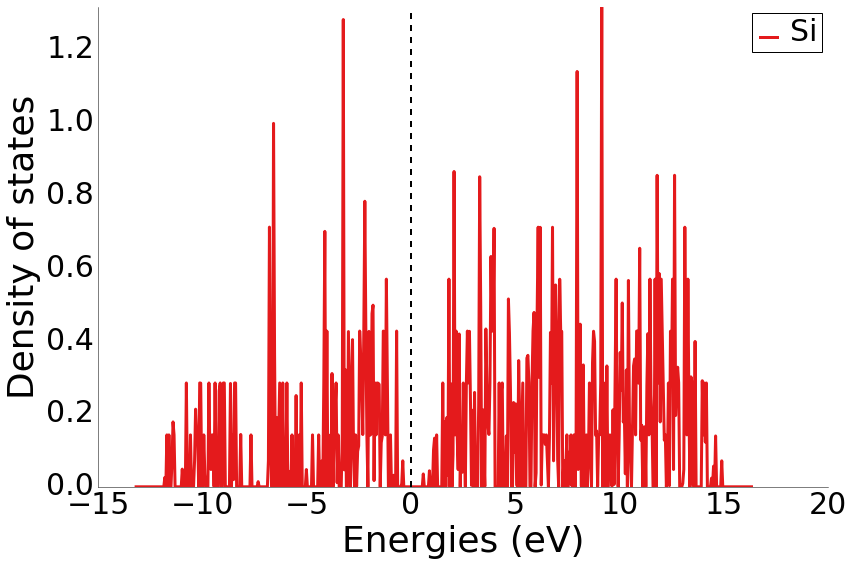

In [29]:
%matplotlib inline

from pymatgen.electronic_structure.plotter import DosPlotter

dos_plotter = DosPlotter()
dos_plotter.add_dos("Si",dos)
dos_plotter.show()